Please note contents of this notebook will produce different values to the lecture notes due to differing seed values and python versions.

## Load Libraries & Data

In [10]:
import platform
print(platform.python_version())

3.8.5


In [11]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]

start = datetime.datetime(2010, 1, 1)
tsy_data = web.DataReader(tsy_tickers, 'fred', start).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOVT_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOME_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOREIGN_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [13]:
return_period = 3

Y = tsy_data.loc[:, ['DGS3MO', 'DGS2', 'DGS10']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOVT_PCT', 'HOME_PCT', 'FOREIGN_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [14]:
dataset.head()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.04,0.95,3.85,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-11,0.05,0.94,3.76,0.01,0.04,0.35,0.95,2.58,3.32,3.85,4.74,0.060799,0.649352,0.303598,2.47
2010-01-14,0.05,0.92,3.68,0.02,0.05,0.34,0.94,2.51,3.23,3.76,4.63,0.060800,0.649352,0.303598,2.46
2010-01-20,0.06,0.86,3.66,0.03,0.05,0.31,0.92,2.45,3.16,3.68,4.54,0.060800,0.649352,0.303598,2.48
2010-01-25,0.08,0.87,3.68,0.02,0.06,0.30,0.86,2.39,3.12,3.66,4.55,0.060800,0.649352,0.303598,2.56


In [15]:
dataset.tail()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2023-10-23,5.59,5.02,4.86,5.57,5.58,5.42,5.05,4.81,4.87,4.86,5.01,0.151968,0.788131,0.225883,1.85
2023-10-26,5.59,5.07,4.88,5.57,5.59,5.39,5.02,4.79,4.86,4.86,5.01,0.151929,0.788131,0.225883,1.82
2023-10-31,5.53,4.83,4.57,5.56,5.59,5.44,5.07,4.82,4.89,4.88,5.04,0.151929,0.788131,0.225883,1.85
2023-11-03,5.54,4.93,4.49,5.53,5.53,5.29,4.83,4.49,4.55,4.57,4.77,0.150704,0.788131,0.225883,1.86
2023-11-08,5.55,5.02,4.63,5.52,5.54,5.34,4.93,4.51,4.54,4.49,4.64,0.150714,0.788131,0.225883,1.84


## Data Exploration

In [16]:
dataset.shape

(1166, 15)

In [17]:
dataset.describe()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,0.927316,1.244846,2.359974,0.854477,0.922607,1.090420,1.241407,1.758945,2.079485,2.359305,3.036166,0.126418,0.730719,0.300628,2.475506
std,1.447067,1.275606,0.824888,1.385476,1.440931,1.426083,1.270815,0.971754,0.879802,0.823361,0.794309,0.033633,0.037318,0.036013,0.480108
min,0.000000,0.110000,0.550000,0.000000,0.000000,0.040000,0.110000,0.210000,0.390000,0.550000,1.180000,0.057293,0.649352,0.225883,1.580000
25%,0.050000,0.320000,1.790000,0.040000,0.050000,0.140000,0.320000,1.080000,1.430000,1.790000,2.580000,0.104543,0.711336,0.266346,2.110000
50%,0.140000,0.700000,2.310000,0.120000,0.140000,0.310000,0.700000,1.620000,2.020000,2.310000,3.020000,0.124126,0.724011,0.308291,2.395000
75%,1.530000,1.670000,2.870000,1.300000,1.517500,1.645000,1.667500,2.227500,2.600000,2.870000,3.547500,0.151905,0.776077,0.334263,2.830000
max,5.620000,5.190000,4.910000,5.950000,5.620000,5.470000,5.190000,4.920000,4.950000,4.910000,5.040000,0.191040,0.788131,0.341355,4.190000


<Axes: xlabel='DATE'>

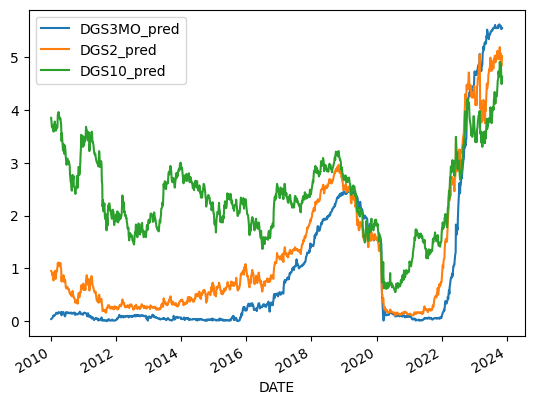

In [18]:
Y.plot()

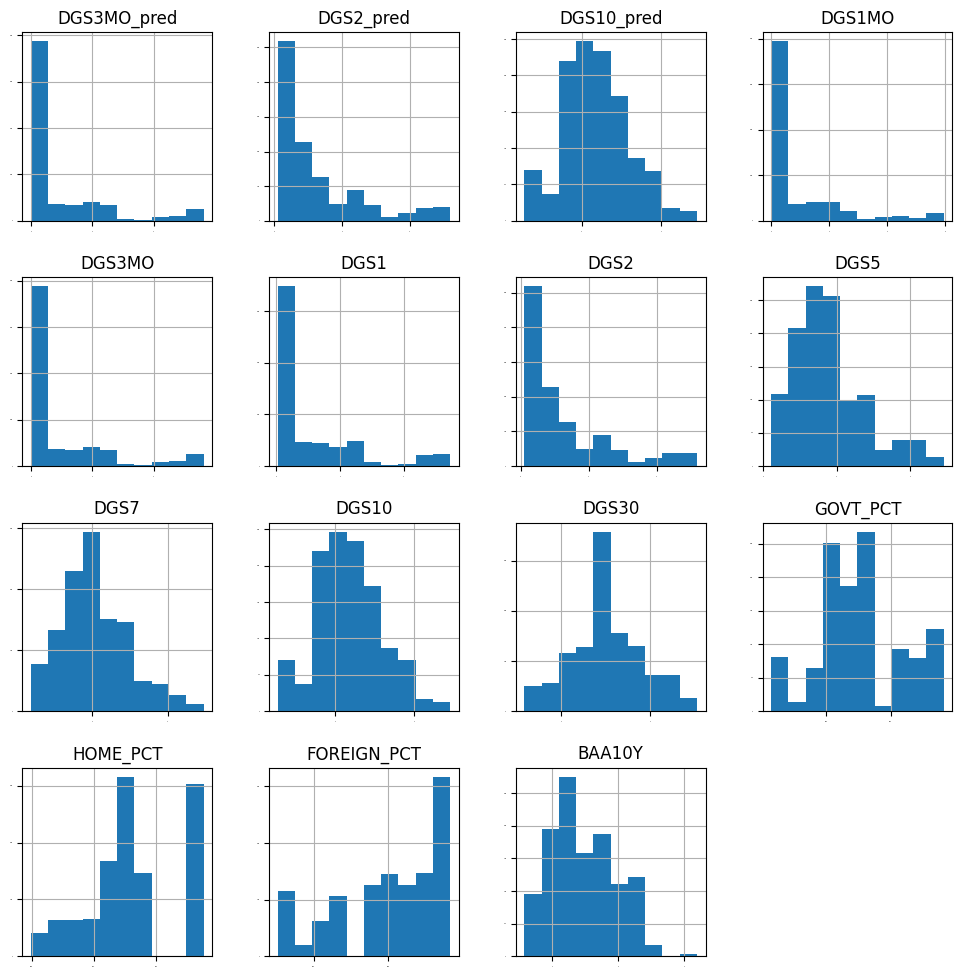

In [19]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The data appears to be skewed for certain variables. We could consider scaling and transforming it.

<Axes: >

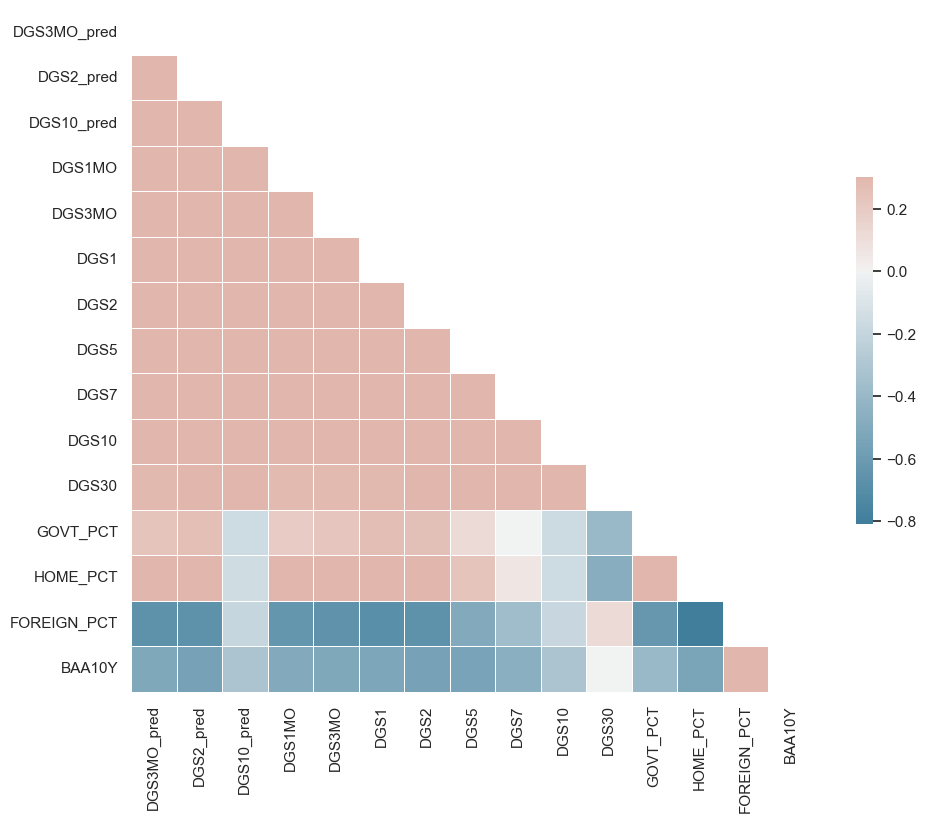

In [20]:
sns.set_theme(style="white")
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: title={'center': 'Correlation Matrix'}>

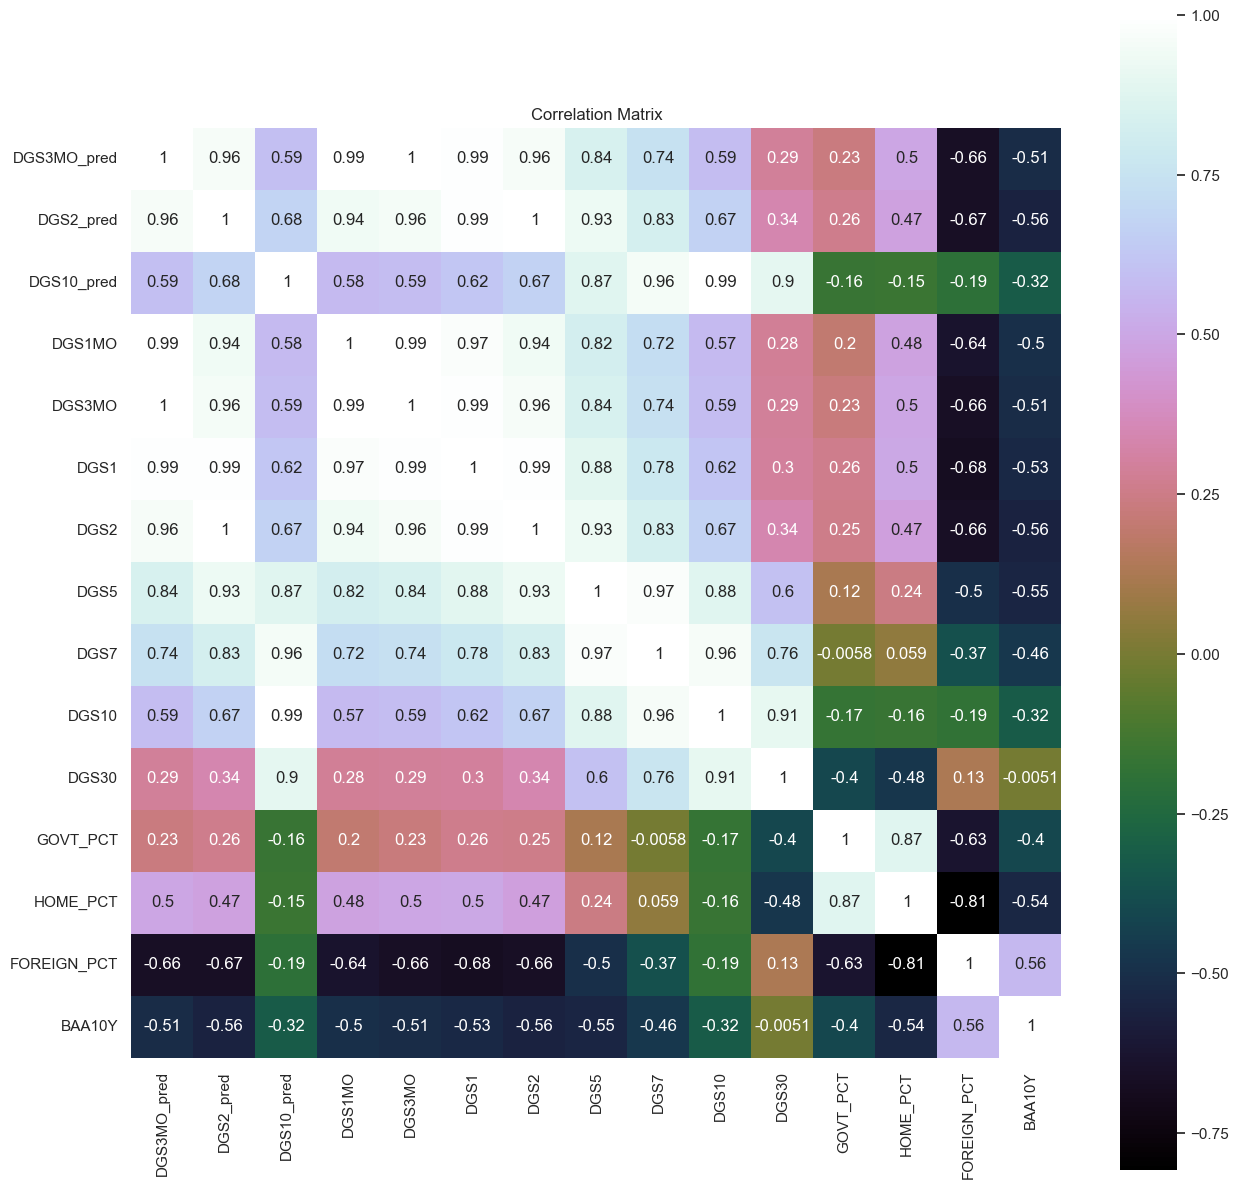

In [21]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation plots we see a negative correlation with the corporate spread and the treasury bonds. We also see mostly positive correlation with the treasuries and different tenors, and as expected a strong correlation between the predicted and current time period of treasury tenor.

<Figure size 1500x1500 with 0 Axes>

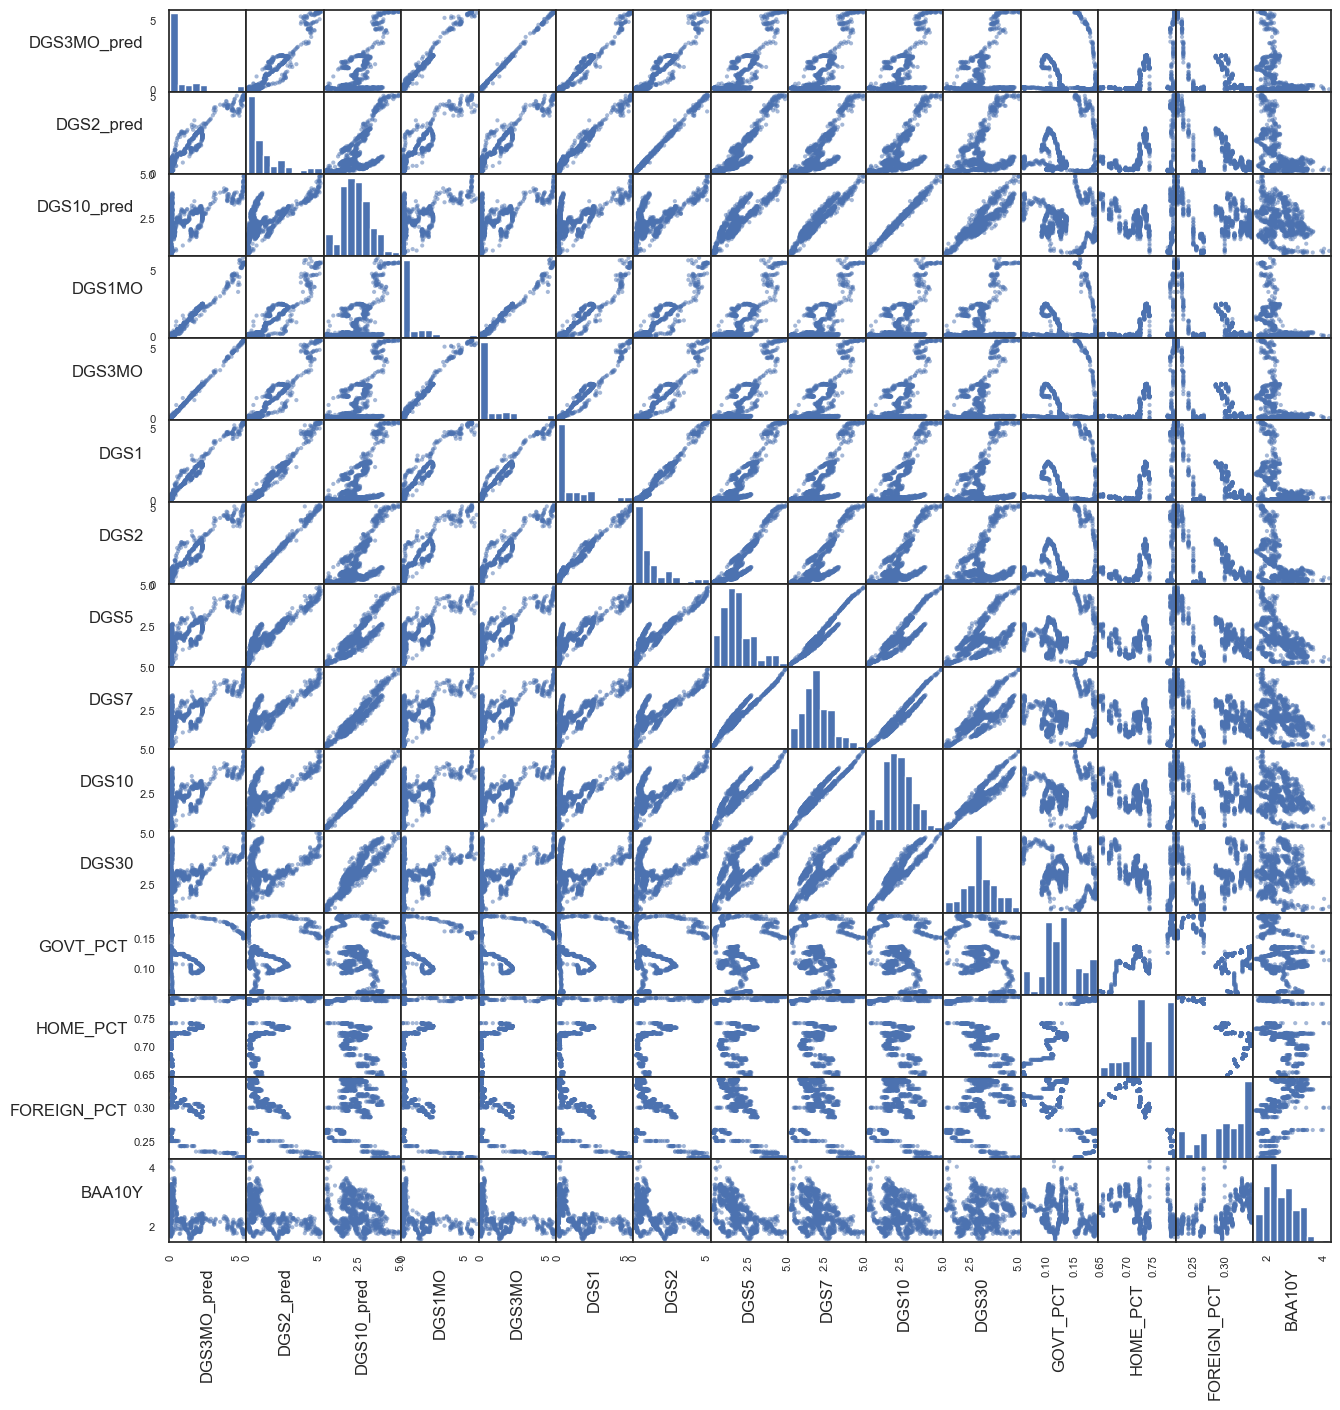

In [22]:
pyplot.figure(figsize=(15,15))
axes = scatter_matrix(dataset,figsize=(15,16))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
pyplot.show()

Lets have a look at the time series analysis  of the tenors we are trying to predict.

#### 3 Month

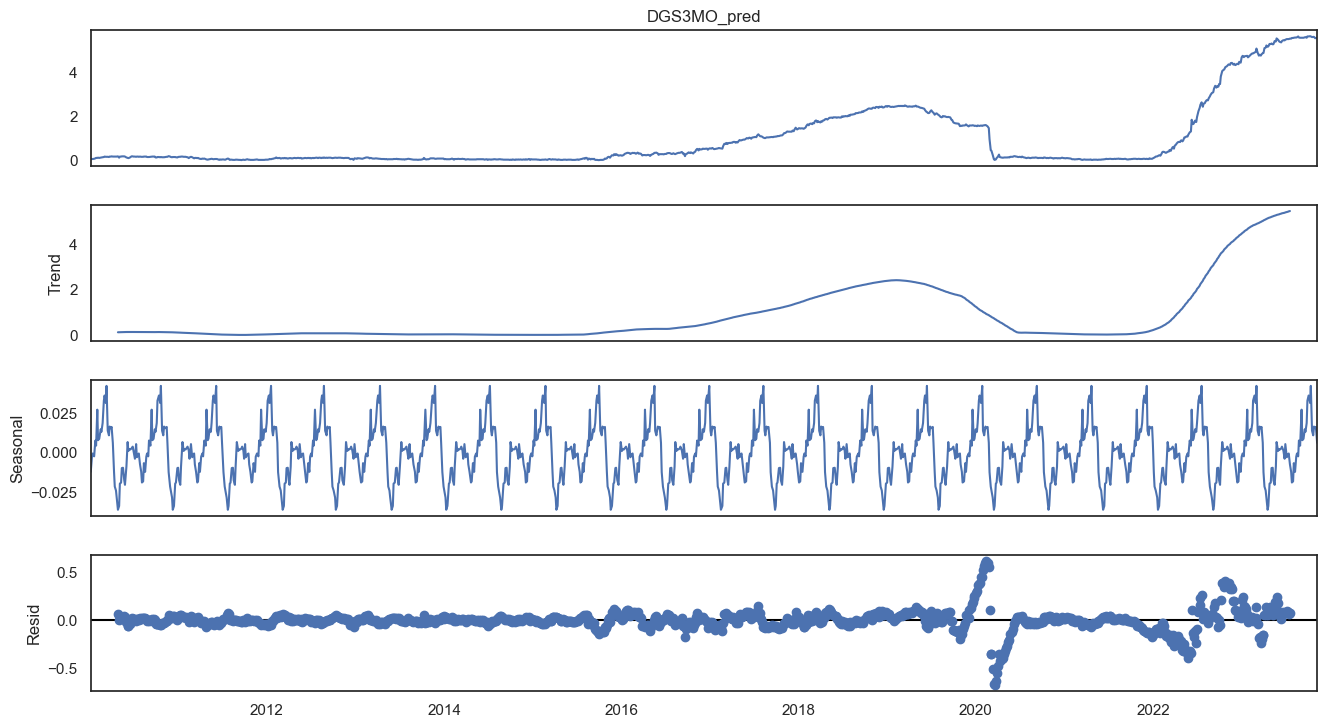

In [23]:
temp_Y = dataset['DGS3MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

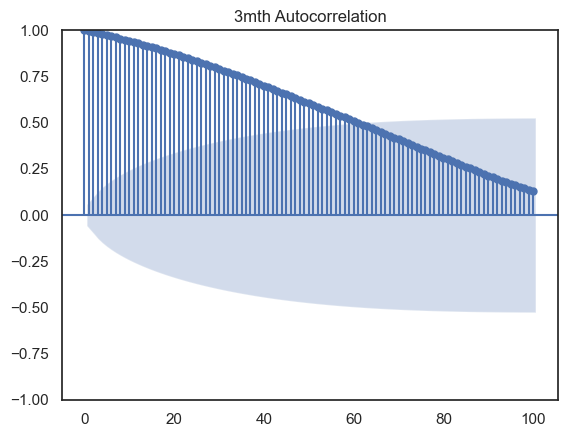

In [24]:
plot_acf(dataset["DGS3MO_pred"], lags=100)
plt.title("3mth Autocorrelation")
plt.show()

#### 2 Year

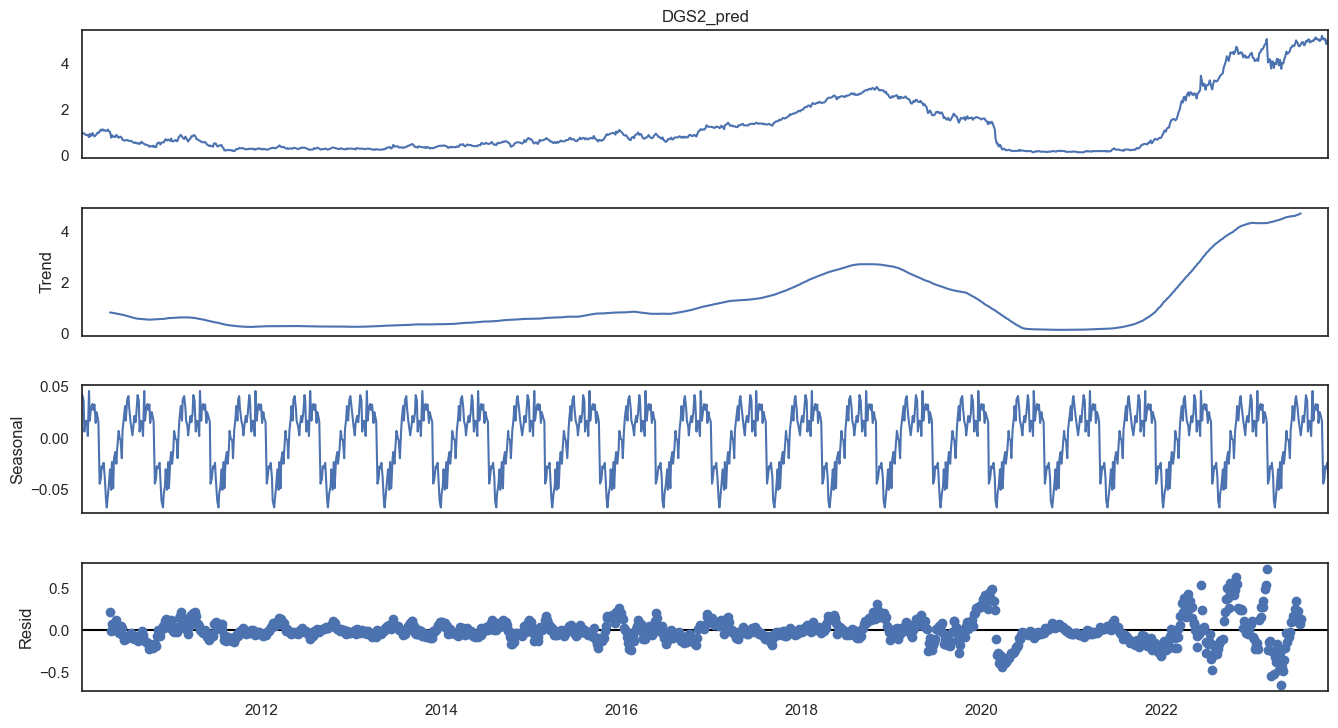

In [25]:
temp_Y = dataset['DGS2_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

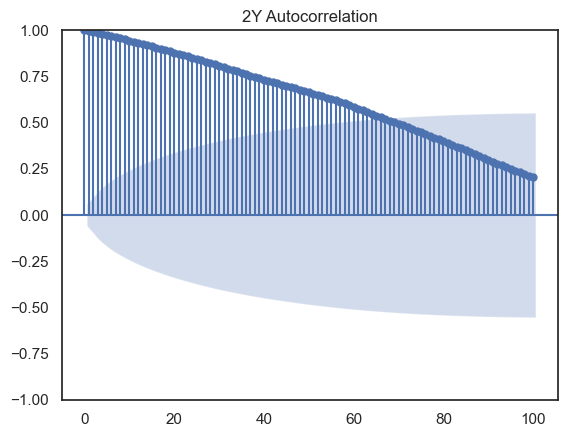

In [26]:
plot_acf(dataset["DGS2_pred"], lags=100)
plt.title("2Y Autocorrelation")
plt.show()

#### 10 Year

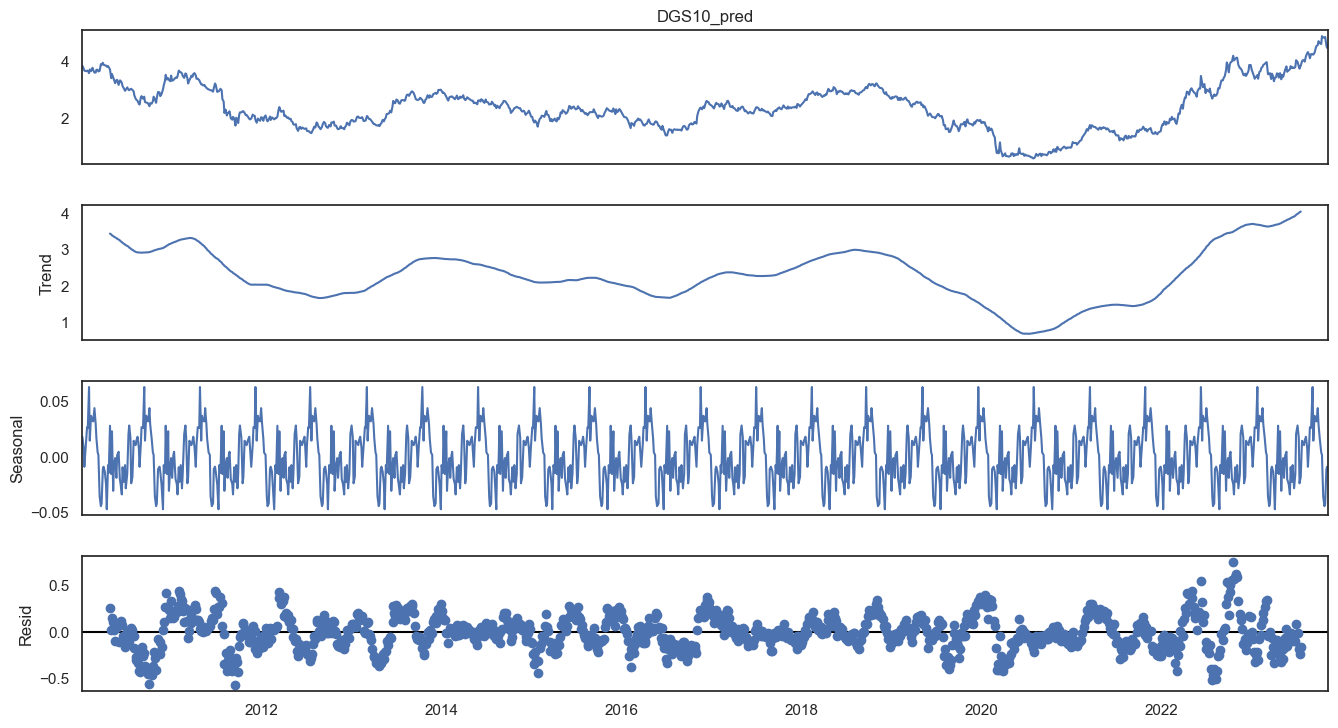

In [27]:
temp_Y = dataset['DGS10_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

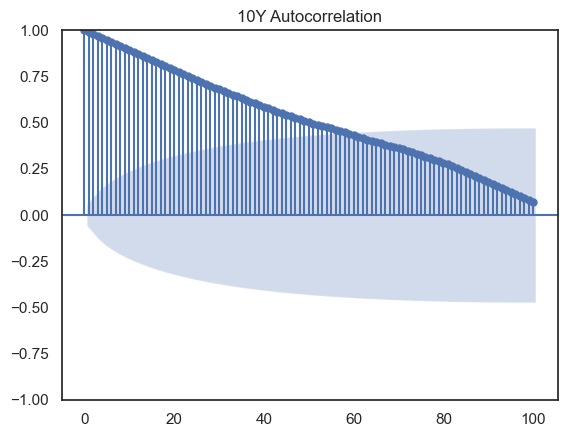

In [28]:
plot_acf(dataset["DGS10_pred"], lags=100)
plt.title("10Y Autocorrelation")
plt.show()

We see a regime change due to the impact of covid in 2020, which is much more pronounced in the 3mth and 2y then it is in the 10y. Trends are also clearly visible in the 3mth and 2y, but less so in the 10y. From the autocorrelation plots we also see a strong correlation with lagged variables up until the 50 to 60 differences (of 3 day periods). It would therefore probably be worth investigating models with time differences.

## Feature Selection

In [29]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(col)
    print(featureScores.nlargest(10,'Score'))
    print('--------------')

DGS3MO_pred
          Specs         Score
1        DGS3MO  1.141667e+06
0        DGS1MO  9.286255e+04
2          DGS1  4.850495e+04
3          DGS2  1.434128e+04
4          DGS5  2.878328e+03
5          DGS7  1.400978e+03
10  FOREIGN_PCT  9.168435e+02
6         DGS10  6.220931e+02
11       BAA10Y  4.140538e+02
9      HOME_PCT  3.833807e+02
--------------
DGS2_pred
          Specs          Score
3          DGS2  321594.775303
2          DGS1   48038.291560
1        DGS3MO   12783.774519
0        DGS1MO    8634.968542
4          DGS5    7115.412113
5          DGS7    2528.603570
6         DGS10     945.287286
10  FOREIGN_PCT     929.398071
11       BAA10Y     519.644956
9      HOME_PCT     333.830503
--------------
DGS10_pred
          Specs         Score
6         DGS10  93395.547839
5          DGS7  12783.295077
7         DGS30   4957.905616
4          DGS5   3802.035058
3          DGS2    964.028903
2          DGS1    722.029997
1        DGS3MO    618.076788
0        DGS1MO    576.699

It should not come as a suprise that for each of the predicted variables, the most important feature is just the lagged time period of that feature.

## Evaluate Some Models Quickly

In [30]:
validation_size = 0.2
seed = 10
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [31]:
num_folds = 10
scoring = 'neg_mean_squared_error'

In [32]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('MLP', MLPRegressor(random_state=seed)))

In [33]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation), axis=0)
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train), axis=0)
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.005718690799337225 
Std CV Error: (0.0028153345909270482) 
Training Error:
DGS3MO_pred    0.001965
DGS2_pred      0.006162
DGS10_pred     0.008441
dtype: float64 
Test Error:
DGS3MO_pred    0.001289
DGS2_pred      0.003438
DGS10_pred     0.007417
dtype: float64
----------
LASSO: 
Average CV error: 0.5674630479596622 
Std CV Error: (0.10751376443288162) 
Training Error:
DGS3MO_pred    0.477778
DGS2_pred      0.520671
DGS10_pred     0.689373
dtype: float64 
Test Error:
DGS3MO_pred    0.449370
DGS2_pred      0.444285
DGS10_pred     0.642187
dtype: float64
----------
EN: 
Average CV error: 0.28560032983743516 
Std CV Error: (0.04827928901646215) 
Training Error:
DGS3MO_pred    0.192527
DGS2_pred      0.229905
DGS10_pred     0.425688
dtype: float64 
Test Error:
DGS3MO_pred    0.184626
DGS2_pred      0.185356
DGS10_pred     0.403673
dtype: float64
----------
CART: 
Average CV error: 0.012270865171966749 
Std CV Error: (0.004050392628492092) 
Training Error:
DGS3MO_pr

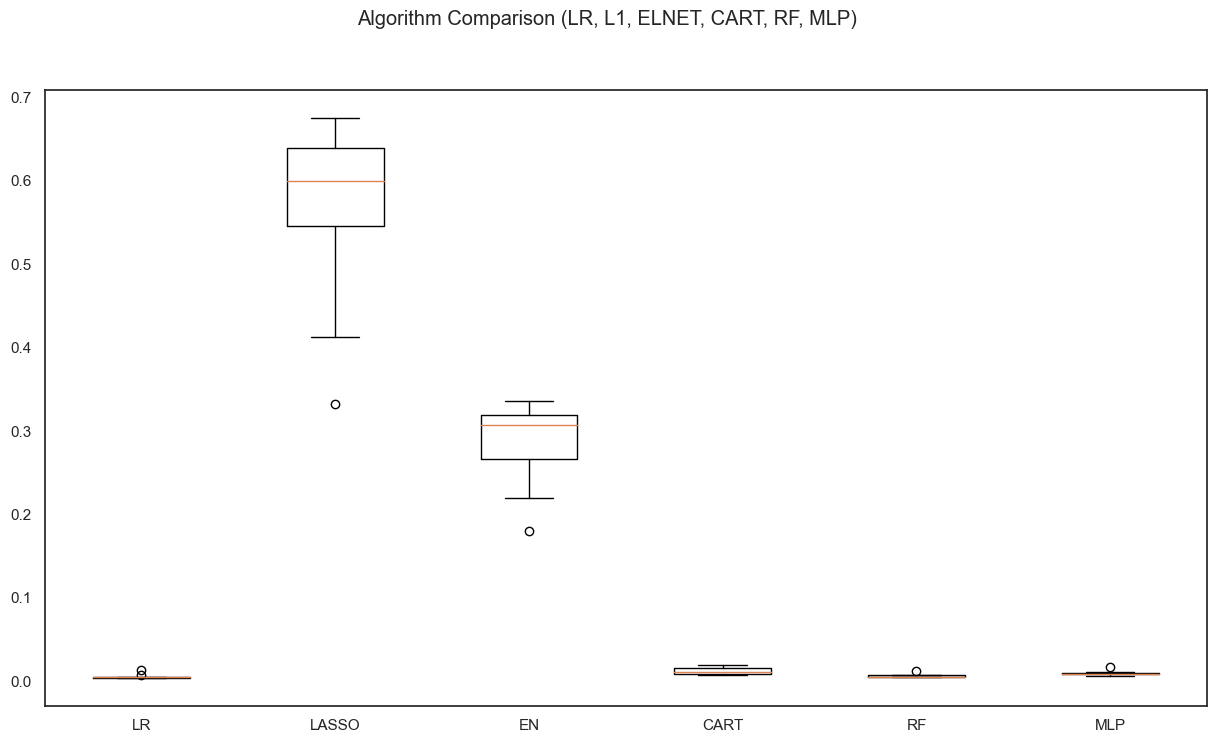

In [34]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison (LR, L1, ELNET, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

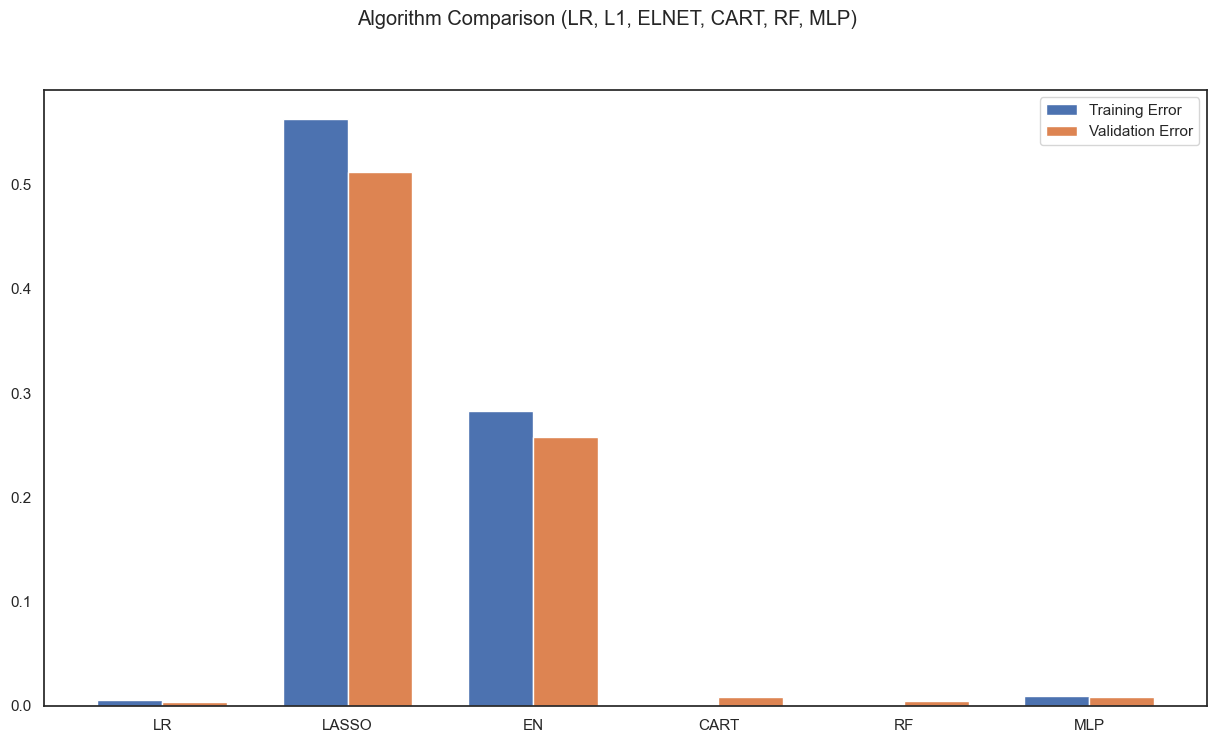

In [35]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35
fig.suptitle('Algorithm Comparison (LR, L1, ELNET, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Training Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [36]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('MLP', MLPRegressor(random_state=seed)))
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation), axis=0)
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train), axis=0)
    train_results.append(train_result)

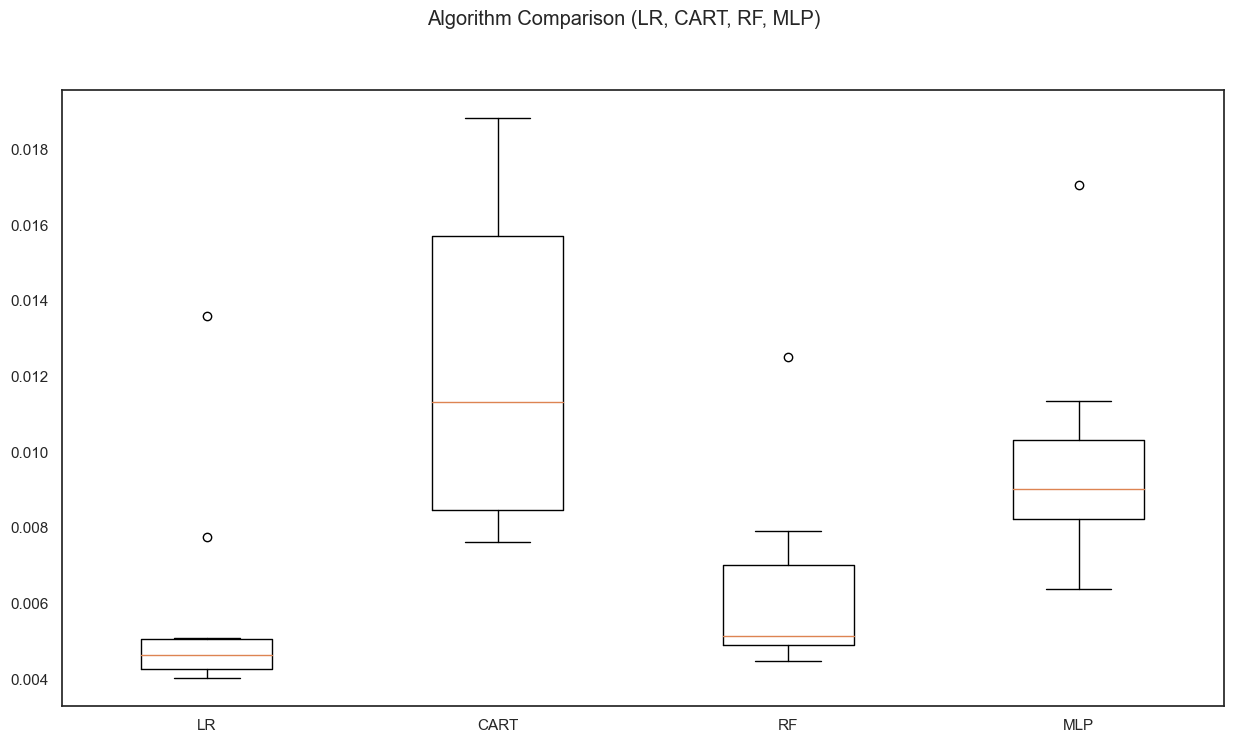

In [37]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison (LR, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

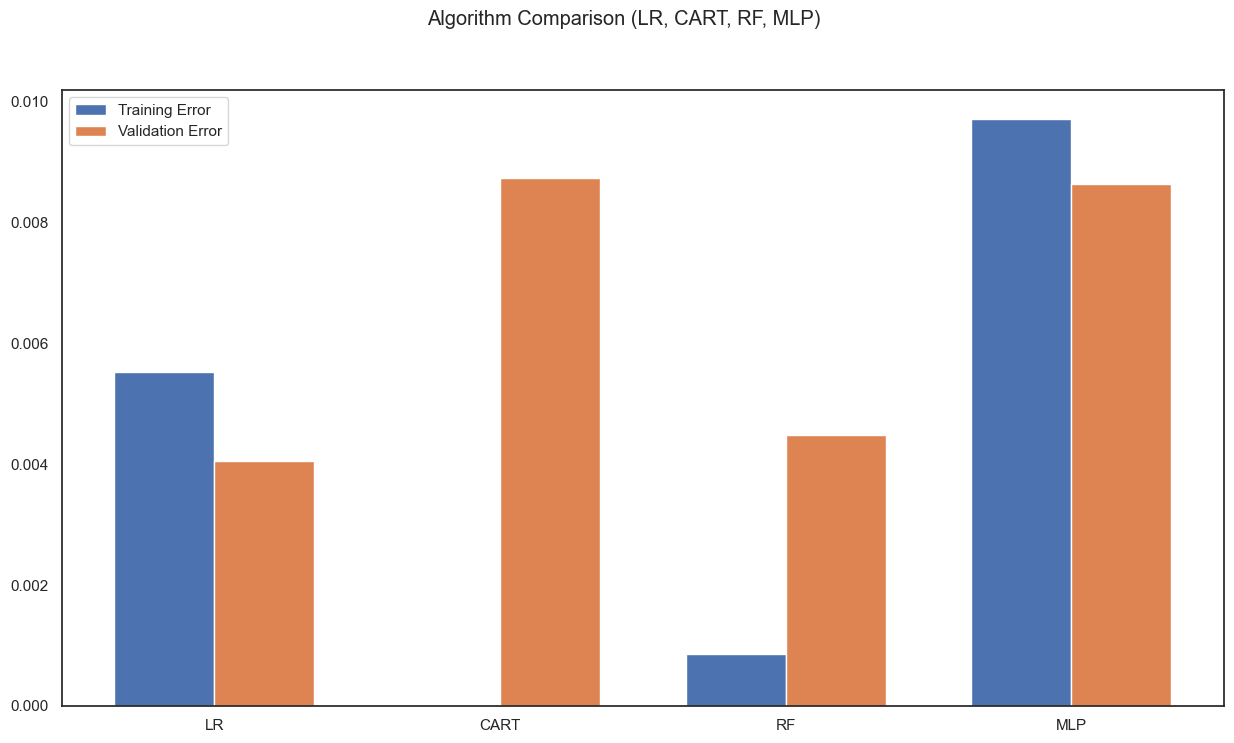

In [38]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35
fig.suptitle('Algorithm Comparison (LR, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Training Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

## Tuning the ANN

In [39]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor(random_state=seed, max_iter=5000)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.009855 using {'hidden_layer_sizes': (20, 30, 20)}
-0.018404 (0.004247) with: {'hidden_layer_sizes': (20,)}
-0.010392 (0.002610) with: {'hidden_layer_sizes': (50,)}
-0.011430 (0.003301) with: {'hidden_layer_sizes': (20, 20)}
-0.009855 (0.002906) with: {'hidden_layer_sizes': (20, 30, 20)}


Optimal MLP has 3 hidden layers with 20, 30, 20 units in each.

## Compariing LR and MLP

In [40]:
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20), random_state=seed)
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)
mse_LR = mean_squared_error(Y_validation, predictions_2)
r2_LR = r2_score(Y_validation, predictions_2)


print("MSE LR = %f, MSE MLP = %f" % (mse_LR, mse_MLP ))
print("R2 LR = %f, R2 MLP = %f" % (r2_LR, r2_MLP ))

MSE LR = 0.004048, MSE MLP = 0.008562
R2 LR = 0.995134, R2 MLP = 0.992266


The LR and MLP models are comparable in performance with the LR model having a slight upperhand. Lets see how they perfom on the test set.

### Predictions

In [41]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (20,30,20), random_state=seed)
modelLR = LinearRegression()
modelRF = RandomForestRegressor(random_state=seed)

model_MLP = modelMLP.fit(X_train, Y_train)
model_LR = modelLR.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predLR = pd.DataFrame(model_LR.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<Axes: xlabel='DATE'>

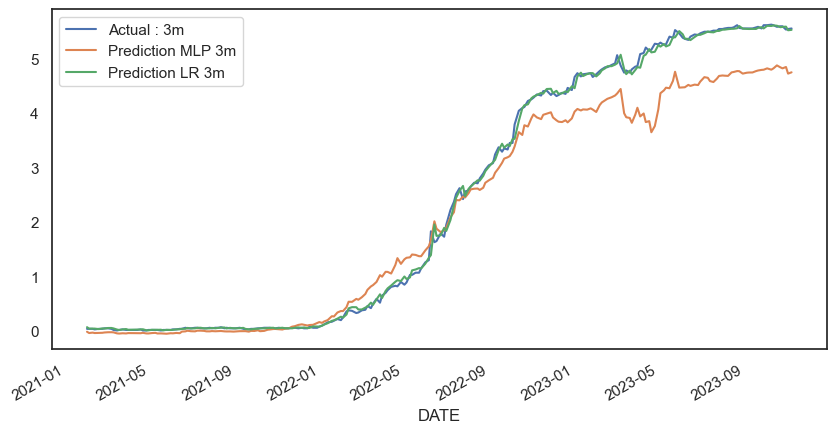

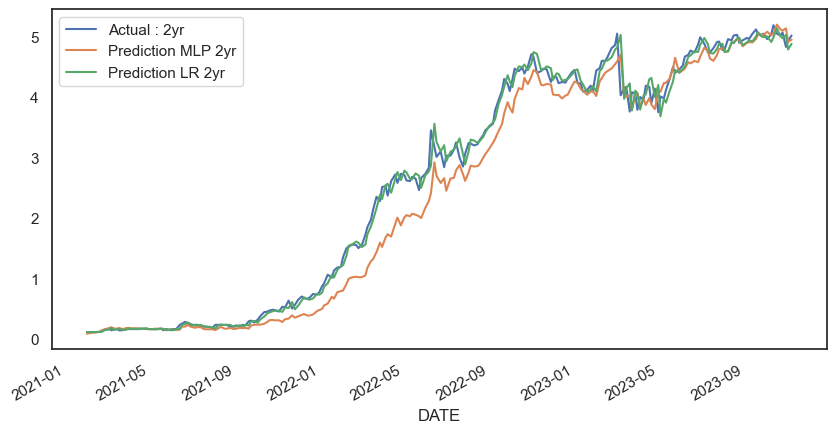

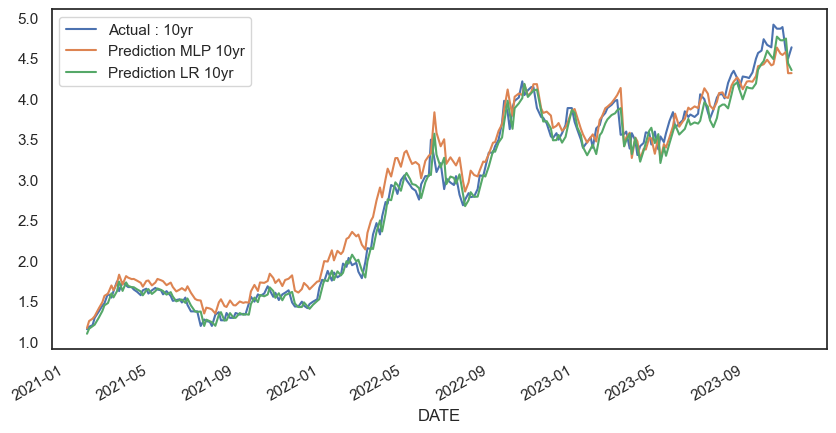

In [42]:
pd.DataFrame({'Actual : 3m': Y_validation.loc[:, 'DGS3MO_pred'],
              'Prediction MLP 3m': Y_predMLP.loc[:, 'DGS3MO_pred'],
              'Prediction LR 3m': Y_predLR.loc[:, 'DGS3MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 2yr': Y_validation.loc[:, 'DGS2_pred'],
              'Prediction MLP 2yr': Y_predMLP.loc[:, 'DGS2_pred'],
              'Prediction LR 2yr': Y_predLR.loc[:, 'DGS2_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 10yr': Y_validation.loc[:, 'DGS10_pred'],
              'Prediction MLP 10yr': Y_predMLP.loc[:, 'DGS10_pred'],
              'Prediction LR 10yr': Y_predLR.loc[:, 'DGS10_pred']}).plot(figsize=(10,5))

We see that actually the LR model is quite powerful, and outperforming the MLP model despite its complexity. Don't discount the power of simple models. Complex models and their ability to overfit can translate into worse outcomes than simpler models with higher bias and lower variance. Indeed in this example, LR is a good predictor for one-period forward predictions of treasury prices.

There is much more tuning that could be done and improvement to this model. For instance there are a number of further steps we could take:
- Try different models (more complex ones)
- Regularise our models
- Spend more time tuning complex models
- Use the difference in the time series data and predict those
- Feature engineering (additional features, scaling and transforming our data)

## References
Adapted from *Machine Learning & Data Science Blueprints for Finance*; Tatsat et al.